# Convolutional Auto-Encoder

In [1]:
# Imports
#!pip install mxnet
from convvae import ConvVae
import numpy as np
import PIL
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
from sklearn.model_selection import train_test_split
# !pip install tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
import Neurosmash

# These are the default environment arguments. They must be the same as the values that are set in the environment GUI.
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to (127.0.0.1 by default)
port       = 13000       # Port number that the TCP/IP interface listens to (13000 by default)

# This is the size of the texture that the environment is rendered.
# This is set to 784 by default, which will result in a crisp image but slow speed.
# You can change the size to a value that works well for your environment but should not go too low.
size       = 64 # 96, 192  # THE VAE MIGHT ONLY WORK WITH 64

# This is the simulation speed of the environment. This is set to 1 by default.
# Setting it to n will make the simulation n times faster.
# In other words, less (if n < 1) or more (if n > 1) simulation time will pass per step.
# You might want to increase this value to around 10 if you cannot train your models fast enough
# so that they can sample more states in a shorter number of steps at the expense of precision.
timescale  = 5 #5

# This is an example agent.
# It has a step function, which gets reward/state as arguments and returns an action.
# Right now, it always outputs a random action (3) regardless of reward/state.
# The real agent should output one of the following three actions:
# none (0), left (1) and right (2)
agent = Neurosmash.Agent() 

# This is the main environment.
# It has a reset function, which is used to reset the environment before episodes.
# It also has a step function, which is used to which steps one time point
# It gets an action (as defined above) as input and outputs the following:
# end (true if the episode has ended, false otherwise)
# reward (10 if won, 0 otherwise)
# state (flattened size x size x 3 vector of pixel values)
# The state can be converted into an image as follows:
# image = np.array(state, "uint8").reshape(size, size, 3)
# You can also use to Neurosmash.Environment.state2image(state) function which returns
# the state as a PIL image
environment = Neurosmash.Environment(ip, port, size, timescale)



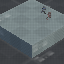

In [3]:
# The following steps through an entire episode from start to finish with random actions (by default)

end, reward, state = environment.reset()
nr_images = 5000
shape = np.array(state, "uint8").reshape(size, size, 3).transpose((2,1,0)).shape
images = np.zeros((nr_images, *shape))
i = 0
while i < nr_images:
    end, reward, state = environment.reset()
    while (end == 0):
        action = agent.step(end, reward, state)
        end, reward, state = environment.step(action)
        images[i] = np.array(state, "uint8").reshape(size, size, 3).transpose((2,0,1))
        i += 1
        if i >= nr_images:
            end = 1

    # Let's run it a few more steps so that the things have time to settle down
    for _ in range(100):
        if i >= nr_images:
            continue
        action = agent.step(end, reward, state)
        end, reward, state = environment.step(action)
        images[i] = np.array(state, "uint8").reshape(size, size, 3).transpose((2,0,1))
        i += 1

environment.state2image(state)


In [4]:
# new_images = np.interp(images, [0,255], [0.0,1.0])
new_images = images/255

In [5]:
# n_samples = 10
# idx = np.random.choice(len(images), n_samples)
# _, axarr = plt.subplots(1, n_samples, figsize=(16,4))
# for i, j in enumerate(idx):
#     axarr[i].imshow(images[j].reshape(shape[1], shape[2], shape[0]).astype(np.uint8))
#     axarr[i].get_xaxis().set_ticks([])
#     axarr[i].get_yaxis().set_ticks([])
# plt.show()

In [36]:
batch_size = 100
train_data, test_data = train_test_split(new_images[:5000], test_size=0.10, random_state=42)

train_iter = mx.io.NDArrayIter(data={'data': train_data}, batch_size = batch_size)
test_iter = mx.io.NDArrayIter(data={'data': test_data}, batch_size = batch_size)

z_size = 32
vae = None
vae = ConvVae(batch_size=batch_size, size=size, z_size=z_size, KL_tolerance_value=0.5, beta=1)
#vae.initialize(ctx=vae.ctx) # Initialising weights
vae.collect_params().initialize(mx.init.Xavier(), ctx=vae.ctx)
# vae.hybridize()  # activates hybrid-mode of the Hybrid-Block
trainer = gluon.Trainer(vae.collect_params(), 'adam', {'learning_rate': .001})

In [37]:

def train_vae(n_epochs=50, print_period=10):
    training_loss = []
    validation_loss = []
    outputs = np.zeros((1, *shape))

    for epoch in tqdm_notebook(range(n_epochs), desc='epochs'):
        
        #
        epoch_loss = 0
        train_iter.reset()
        test_iter.reset()

        # Training data
        n_batch_train = 0
        for batch in train_iter:
            n_batch_train += 1
            data = batch.data[0].as_in_context(vae.ctx)
            with autograd.record():
                _, loss = vae(data)
            loss.backward()
            trainer.step(data.shape[0])
            epoch_loss += nd.mean(loss).asscalar()

        # Validation data
        n_batch_val = 0
        epoch_val_loss = 0
        for batch in test_iter:
            n_batch_val += 1
            data = batch.data[0].as_in_context(vae.ctx)
            out, loss = vae(data)
            epoch_val_loss += nd.mean(loss).asscalar()
#             np.append(outputs, out.asnumpy())
#             out = out.asnumpy()
            if epoch+1 == n_epochs:
                outputs = np.concatenate((outputs, out.asnumpy()), axis=0)#out.asnumpy()

        epoch_loss /= n_batch_train
        epoch_val_loss /= n_batch_val

        training_loss.append(epoch_loss)
        validation_loss.append(epoch_val_loss)

        if epoch % max(print_period,1) == 0:
            tqdm.write('Epoch{}, Training loss {:.2f}, Validation loss {:.2f}'.format(epoch, epoch_loss, epoch_val_loss))
    print("done.")
        
    return training_loss, validation_loss, outputs

In [38]:
# training_loss, validation_loss, outputs = train_vae(1)
# print(vae)

Epoch0, Training loss 168.10, Validation loss 98.41
Epoch1, Training loss 61.68, Validation loss 27.17
Epoch2, Training loss 19.94, Validation loss 14.79
Epoch3, Training loss 13.30, Validation loss 12.43
Epoch4, Training loss 11.53, Validation loss 11.06
Epoch5, Training loss 10.82, Validation loss 10.47
Epoch6, Training loss 10.53, Validation loss 10.08
Epoch7, Training loss 10.13, Validation loss 9.96
Epoch8, Training loss 10.03, Validation loss 9.82
Epoch9, Training loss 9.71, Validation loss 9.61

done.


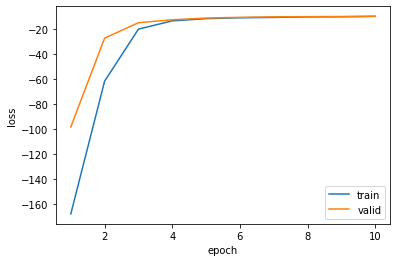

In [39]:
n_epochs = 10
training_loss, validation_loss, outputs = train_vae(n_epochs, print_period=1)
batch_x = np.linspace(1, n_epochs, len(training_loss))
plt.plot(batch_x, -1*np.array(training_loss))
plt.plot(batch_x, -1*np.array(validation_loss))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train', 'valid'])
plt.show()

In [30]:
# plt.plot(batch_x, np.array(training_loss))
# plt.plot(batch_x, np.array(validation_loss))
# plt.legend(['train', 'valid'])
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.show()

(501, 64, 64, 3)


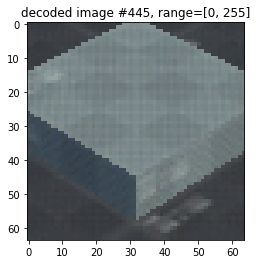

In [58]:

outputs_t = np.transpose(outputs, (0,2,3,1))
print(outputs_t.shape)
max_nr = outputs_t.shape[0]
# rnd = np.random.randint(int(0.8 * max_nr), max_nr)
rnd = np.random.randint(0, max_nr)
# reconstruction = np.transpose(outputs[rnd], (1,2,0))

title=f"decoded image #{rnd}, range="
plt.imshow(np.interp(reconstruction, [0.0,1.0], [0,255]).astype(int))
plt.title(title+"[0, 255]")
plt.show()

# plt.figure()
# plt.imshow(reconstruction)
# plt.title(title+"[0.0, 1.0]")
# plt.show()
# n_samples = batch_size if batch_size < 25 else 10
# indx_samples = np.random.choice(outputs_t.shape[0], n_samples, replace=False)
# canvas = np.empty((size*n_samples, size*n_samples, 3))
# for i, img in enumerate(outputs_t[indx_samples]):
#     x = i // n_samples
#     y = i % n_samples
#     canvas[(n_samples-y-1)*size:(n_samples-y)*size, x*size:(x+1)*size] = img#img.reshape(size, size)
# plt.figure(figsize=(8, 8))        
# plt.imshow(canvas, origin="upper", cmap="Greys")
# plt.axis('off')
# plt.tight_layout()
# plt.title("Reconstructions")
# plt.show()

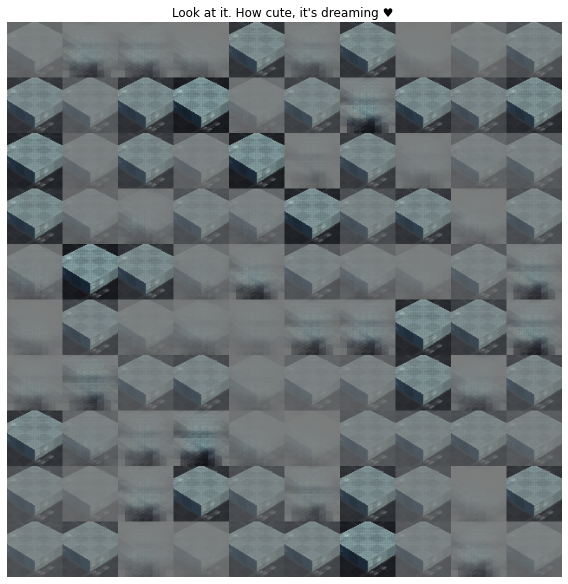

In [50]:
# the dreaming
n_samples = 10
dream_states = vae.dream(n_samples=n_samples)
dream_states = dream_states.asnumpy()
dream_samples = np.transpose(dream_states, (0,2,3,1))

canvas = np.empty((size*n_samples, size*n_samples, 3))
for i, img in enumerate(dream_samples):
    x = i // n_samples
    y = i % n_samples
    canvas[(n_samples-y-1)*size:(n_samples-y)*size, x*size:(x+1)*size] = img#img.reshape(size, size)
plt.figure(figsize=(8, 8))        
plt.imshow(canvas, origin="upper", cmap="Greys")
plt.axis('off')
plt.tight_layout()
plt.title("Look at it. How cute, it's dreaming \u2665 ")
plt.show()